# Alternative Risk Analysis Methods

### Performance against the sector 
The sector is represented by an appropriate ETF index 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import pandas as pd
import json
from urllib.request import Request, urlopen
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

In [6]:
from webapis.guru import Guru
from webapis.yahoo import etf_components

In [7]:
guru = Guru('73142da8657cc5dfa541b546d1560131:4886c27790bc76bd5e076340a403ade5')

In [8]:
charts = guru.charts(['TSM', 'SWKS', 'NVDA', 'TOELY', 'SOXX'])

In [9]:
symbols = etf_components('SOX')
print(symbols)

['MRVL', 'SWKS', 'ASML', 'MKSI', 'CCMP', 'MPWR', 'SMTC', 'ADI', 'TXN', 'AMD', 'XLNX', 'ENTG', 'MXIM', 'CRUS', 'MCHP', 'NXPI', 'AMAT', 'AVGO', 'TSM', 'INTC', 'LRCX', 'KLAC', 'SLAB', 'ON', 'QCOM', 'QRVO', 'NVDA', 'TER', 'CREE', 'MU']


In [10]:
ratios = guru.quarterly('TSM', 'valuation_ratios')

In [11]:
pe = ratios['Shiller PE Ratio']['2019-06']
pe

23.73

In [12]:
inc = guru.quarterly('TSM', 'income_statement')

In [13]:
(
    inc['EPS (Diluted)']['2019-06']+
    inc['EPS (Diluted)']['2019-03']+
    inc['EPS (Diluted)']['2018-12']+
    inc['EPS (Diluted)']['2018-09'])

2.054593358409

In [14]:
inc['Revenue']['2019-06']

7704.03186372

In [15]:
inc['EPS (Diluted)'][-1]

0.410680899343

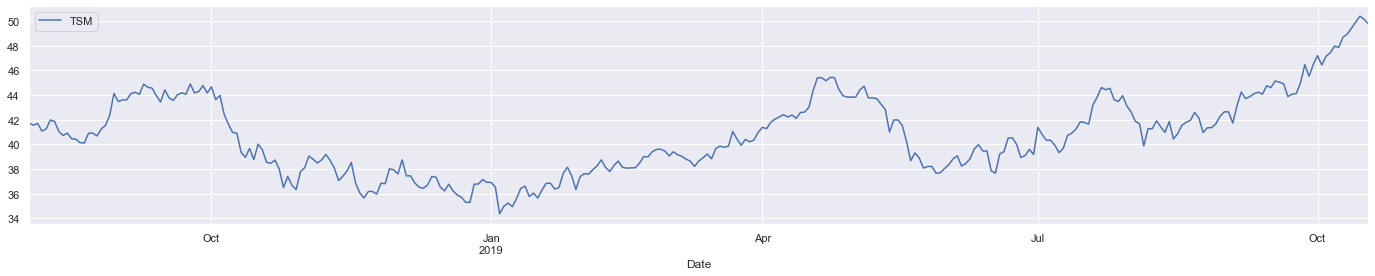

In [16]:
sns.set(rc={'figure.figsize': (24,4)})
csub=charts['20180801':]
csub.plot(y=['TSM']);

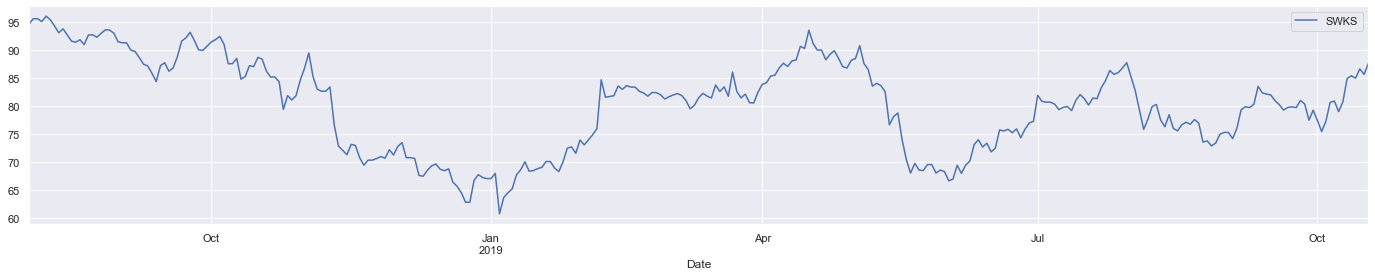

In [17]:
csub.plot(y=['SWKS']);

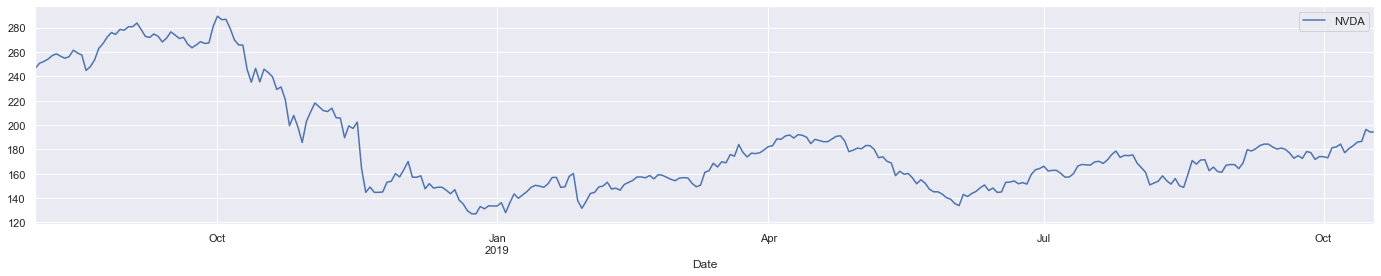

In [18]:
csub.plot(y=['NVDA']);

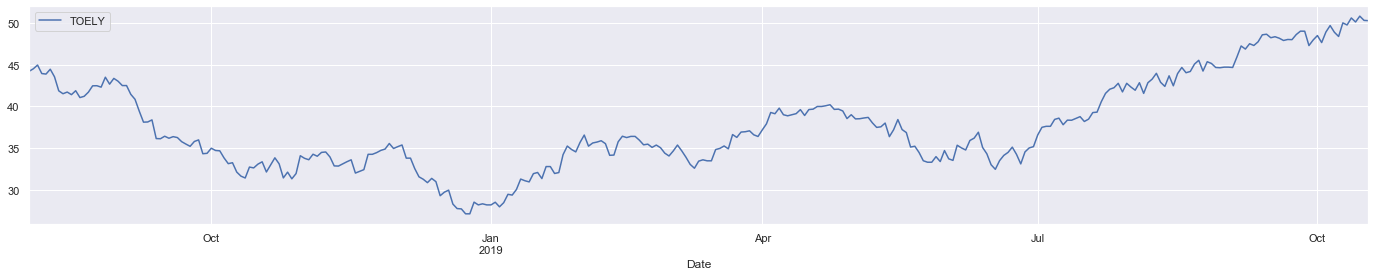

In [19]:
csub.plot(y=['TOELY']);

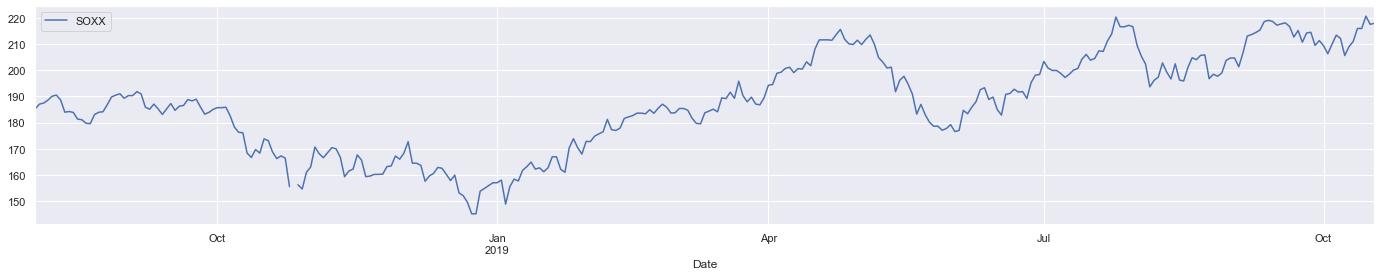

In [20]:
csub.plot(y=['SOXX']);

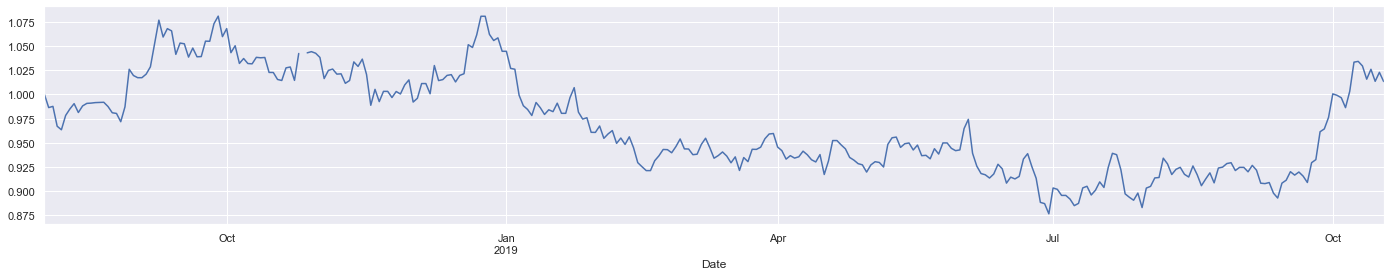

In [21]:
(csub['TSM']/csub['TSM'][0] / csub['SOXX'] * csub['SOXX'][0]).plot();

In [ ]:
csub['TOP SEMI'] = 

In [23]:
w_tsm = 2100 * charts['TSM'][0]
w_toely = 200 * charts['TOELY'][0]
w_swks = 400 * charts['SWKS'][0]
w_nvda = 150 * charts['NVDA'][0]
w_tot = w_tsm + w_toely + w_swks + w_nvda
w_tsm /= w_tot
w_toely /= w_tot
w_swks /= w_tot
w_nvda /= w_tot

In [24]:
csub['TOP SEMI'] = w_tsm * csub['TSM'] + w_toely * csub['TOELY'] + w_swks * csub['SWKS'] + w_nvda * csub['NVDA']

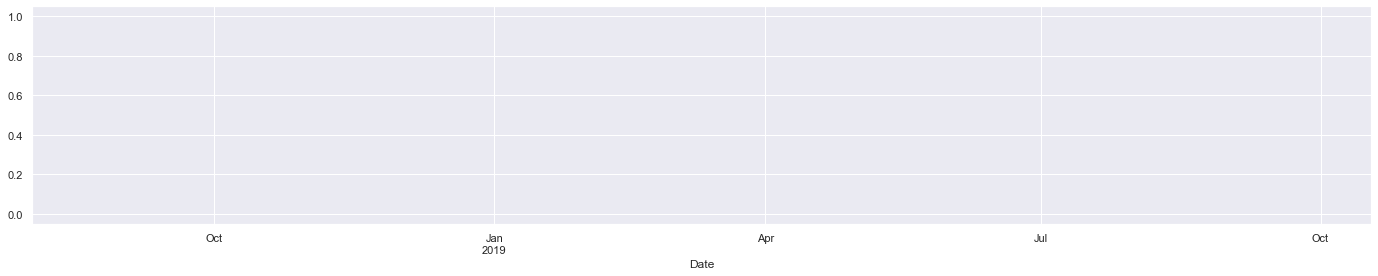

In [25]:
csub['TOP SEMI'].plot();

In [26]:
top_semi_rel = (csub['TOP SEMI']/csub['TOP SEMI'][0] - csub['SOXX']/csub['SOXX'][0])

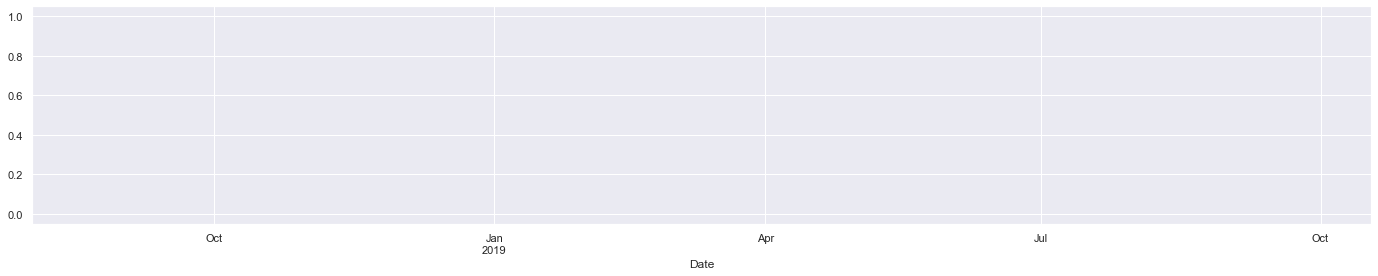

In [27]:
top_semi_rel.plot();

In [28]:
start='1601'
period = charts['20%s01'%start:]
delta = period.iloc[0]['TSM'] - period.iloc[0]['SOXX']
period['SOXX'] = period['SOXX'] + delta 

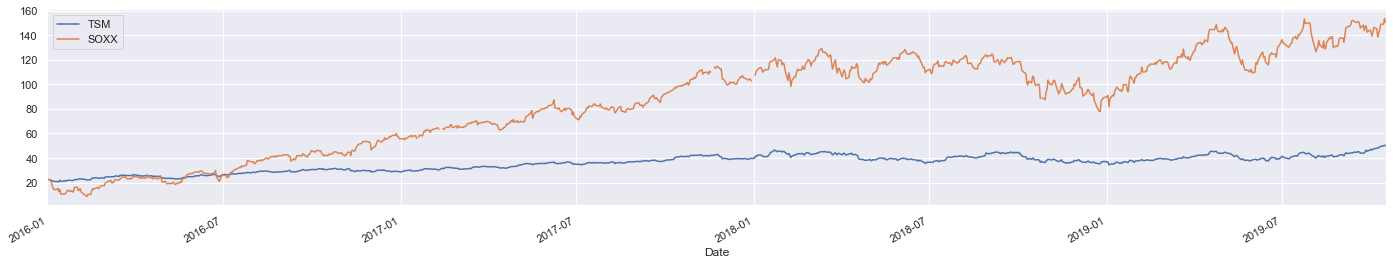

In [29]:
period.plot(y=['TSM', 'SOXX']);

### Stop Loss alert
Lower limit smart below the 20d/80d moving averages

In [30]:
period['tsm10'] = period.rolling("10d").mean()['TSM']
period['tsm20'] = period.rolling("20d").mean()['TSM']
period['tsm50'] = period.rolling("50d").mean()['TSM']
period['tsm80'] = period.rolling("80d").mean()['TSM']
period['stop80'] = period['tsm80'] * 0.95
period['stop20'] = period['tsm20'] * 0.9
period['stop'] = np.min([period['stop80'], period['stop20']], axis=0)

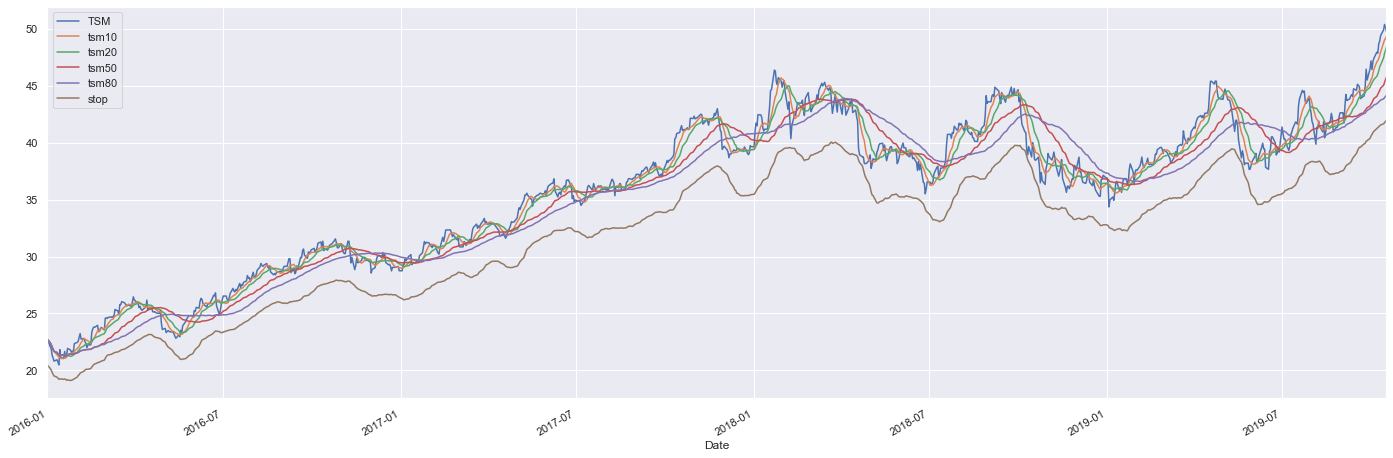

In [31]:
sns.set(rc={'figure.figsize': (24,8)})
period.plot(y=['TSM', 'tsm10', 'tsm20', 'tsm50', 'tsm80', 'stop']);

### Cyclic draw downs as risk measure
We look at the sections between the crossings of 50d and 80d moving averages. We then identify maxima in those sections where the 50d moving average is on top, minima in the others.
Every drop from a maximum to the subsequent minimum is called a cyclic draw down, as is appears at the mean reversion frequency.

In [32]:
diffs = period['tsm50'] - period['tsm80']
d0 = np.sign(diffs)
d = (d0 * d0.shift()).dropna()
d = (1 - d) / 2
d = (d * d0).dropna()

sections = period.copy()

up = d.where(d == 1)
up = up * sections['tsm50']

down = d.where(d == -1)
down = - down * sections['tsm50']

ups = sections['TSM'].where(up > 0 ).dropna().keys()
downs = sections['TSM'].where(down > 0 ).dropna().keys()

n = max(len(ups), len(downs)) - 1

sections['high'] = np.nan
sections['low'] = np.nan

for i in range(n):
    h = ups[i]
    l = downs[i]
    h1 = ups[i+1]

    section = sections['TSM'][h:l]
    local_max = np.max(section)
    
    pos = section.where(section==local_max)
    pos_t = pos.dropna().keys()[0]
    sections['high'][pos_t] = sections['TSM'][pos_t]    
    
    section = sections['TSM'][l:h1]
    local_min = np.min(section)

    pos = section.where(section==local_min)
    pos_t = pos.dropna().keys()[0]
    sections['low'][pos_t] = sections['TSM'][pos_t]    
    

[(Timestamp('2016-03-30 00:00:00'), -0.1375661375661376),
 (Timestamp('2016-10-25 00:00:00'), -0.08906497622820926),
 (Timestamp('2017-06-08 00:00:00'), -0.04045614987781686),
 (Timestamp('2017-11-24 00:00:00'), -0.0939753431030472),
 (Timestamp('2018-01-26 00:00:00'), -0.07217847769028865),
 (Timestamp('2018-04-12 00:00:00'), -0.19019384264538206),
 (Timestamp('2018-09-24 00:00:00'), -0.23457340164847407),
 (Timestamp('2019-04-23 00:00:00'), -0.17084984588287108)]

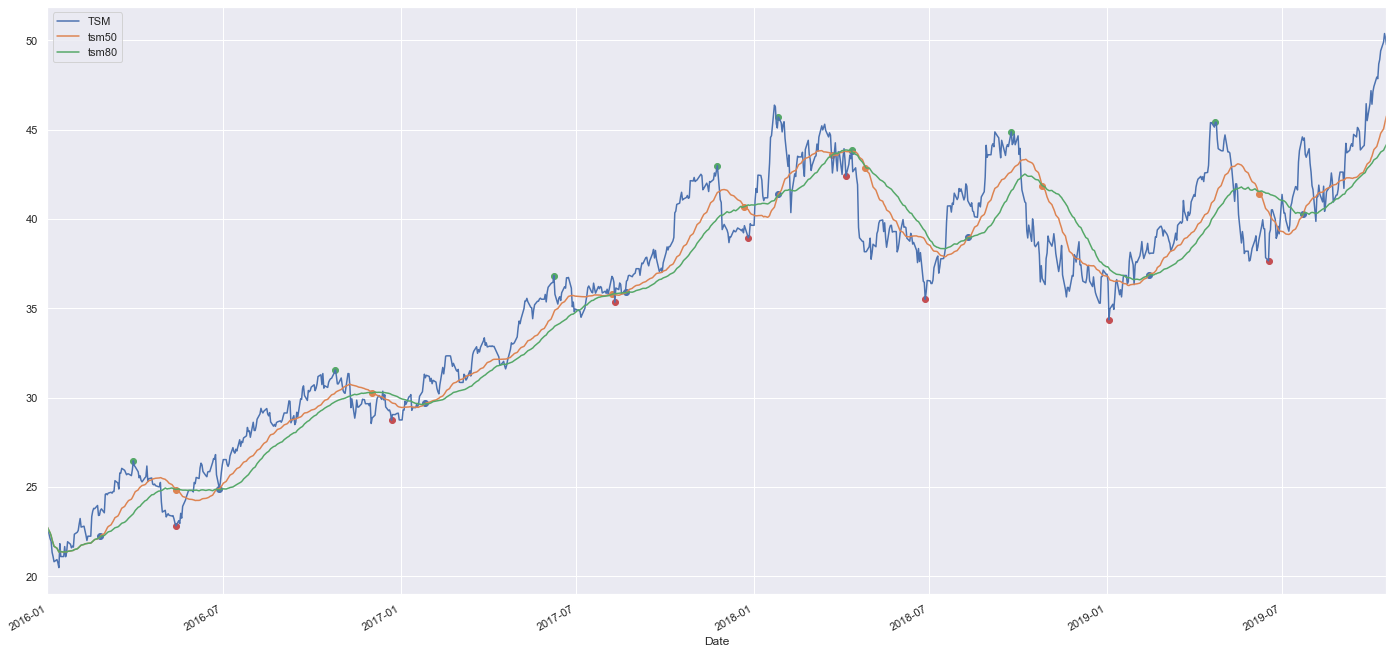

In [34]:
sns.set(rc={'figure.figsize': (24,12)})
sections.plot(y=['TSM', 'tsm50', 'tsm80'])
plt.scatter(x=up.index, y=up.to_numpy())
plt.scatter(x=down.index, y=down.to_numpy())
plt.scatter(x=up.index, y=sections['high'])
plt.scatter(x=up.index, y=sections['low']);

drops = (sections['low'].dropna().to_numpy() - sections['high'].dropna().to_numpy()) / sections['high'].dropna().to_numpy()
highs = sections['high'].dropna().index.to_list()
list(zip(highs, drops))

### std dev w/r/t the rolling average
The following chart helps us to calculate the expected worst case movement of the stock price w/r/t the time passed. E.g.: The std dev from the 20d moving average is about 1.35 Dollar. A multiple of this value can be used as a down fall risk measure.

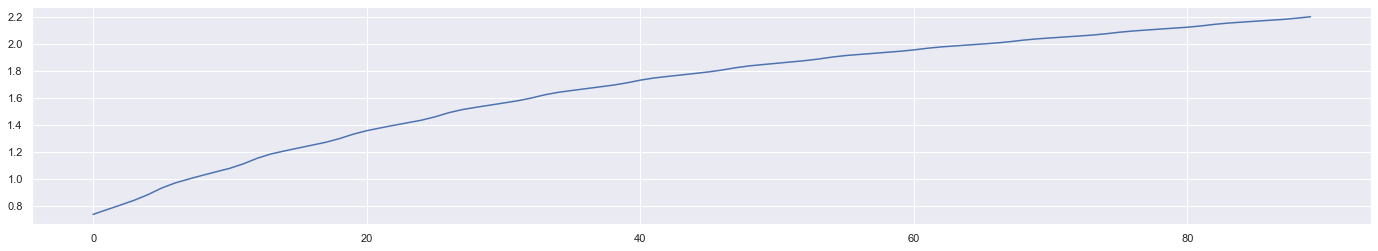

In [30]:
stddevs = [ (period.rolling("%sd" % d).mean()['TSM'] - period['TSM']).std() for d in range(10, 100)]
plt.plot(stddevs);

In [32]:
diffs = period.rolling("80d").mean()['TSM'] - period['TSM']

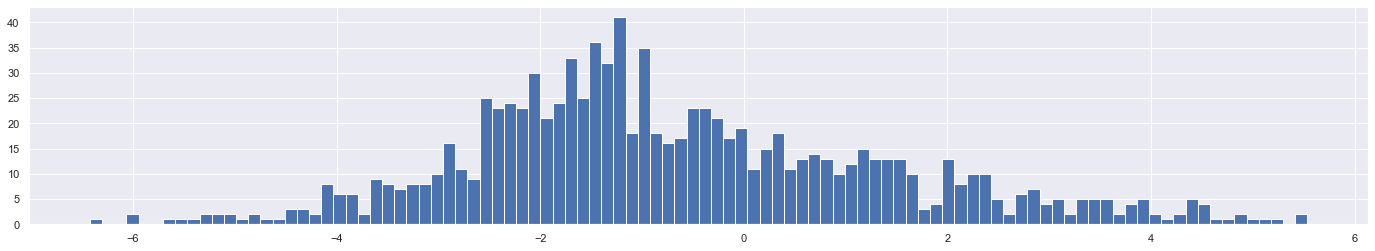

In [33]:
diffs.hist(bins=100);